# Correlation Networks analysis with EMD

In [1]:
from lrgsglib.core import *
#
cwd = Path.cwd()
while cwd.name != 'lrg_eegfc':
    %cd ..
    cwd = Path.cwd()
#
from src.lrg_eegfc.core import *
#
mat_path = Path('data') / 'stereoeeg_patients'
patients_list = [p.name for p in Path(mat_path).iterdir() 
                 if p.is_dir() and p.name.startswith('Pat_')]
#
phase_labels = ['rsPre', 'taskLearn', 'taskTest', 'rsPost']
param_keys_list = ['fs', 'fcutHigh', 'fcutLow', 'filter_order', 'NotchFilter', 'DataDimensions']

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


## Input Data

### Data import

In [2]:
ch_names = loadmat(mat_path / 'ChannelNames.mat')
ch_names = [name[0] for name in ch_names['ChannelNames'][0]]
ch_int_name_map = {i: name for i, name in enumerate(ch_names)}

In [3]:
data_dict = {}
for pat in [patients_list[1]]:
    data_dict[pat] = {}
    for phase in phase_labels:
        data_dict[pat][phase] = {}
        try:
            # Load the .mat file using scipy.io.loadmat
            # This is the preferred method for loading .mat files
            tmp_mat = loadmat(str(mat_path / pat / f'{phase}'))
        except Exception as e:
            # If loading fails, fall back to h5py
            print(f'{type(e).__name__} loading {pat} {phase}: {e}. ',
                  f'Continuing with h5py', end='\r', flush=True)
            tmp_mat = {}
            f = h5py.File(mat_path / pat / f'{phase}.mat')
            for k, v in f.items():
                tmp_mat[k] = np.array(v)
            pass
        data_dict[pat][phase]['data'] = tmp_mat['Data']
        tmp_shape = data_dict[pat][phase]['data'].shape
        if tmp_shape[0] > tmp_shape[1]:
            # Transpose the data if the first dimension is bigger
            data_dict[pat][phase]['data'] = data_dict[pat][phase]['data'].T
        try:
            # Extract the parameters from the loaded data
            # Check if 'Parameters' is in the loaded data
            # If not, skip to the next iteration
            for param in tmp_mat['Parameters'].dtype.names:
                if param in param_keys_list:
                    data_dict[pat][phase][param] = tmp_mat['Parameters'][param][0][0][0][0]
        except:
            print(f'No parameters found for {pat} {phase}', end='\r', flush=True)
            continue

### EMD for a single dataset

In [17]:
patient = 'Pat_02'
phase = 'rsPre'
filttime = 100000
data_Pat_rsPre = data_dict[patient][phase]['data'][:, :filttime]

In [18]:
imf = [emd.sift.sift(signal) for signal in tqdm(data_Pat_rsPre)]


100%|██████████| 117/117 [00:51<00:00,  2.29it/s]


In [103]:
n_imf = 3
data = []
for channel in range(len(imf)):
    sig = imf[channel][:, n_imf]
    data.append(sig)
data = np.array(data)

In [104]:
Cc = np.abs(np.corrcoef(data))
np.fill_diagonal(Cc, 0)

G = nx.from_numpy_array(Cc)
Th, Einf, Pinf = compute_threshold_stats(G)

Computing threshold stats: 100%|██████████| 400/400 [00:10<00:00, 39.67it/s]


In [105]:
Pinfdiff = np.diff(Pinf)
th = Th[np.where(Pinfdiff != 0)[0][0]]

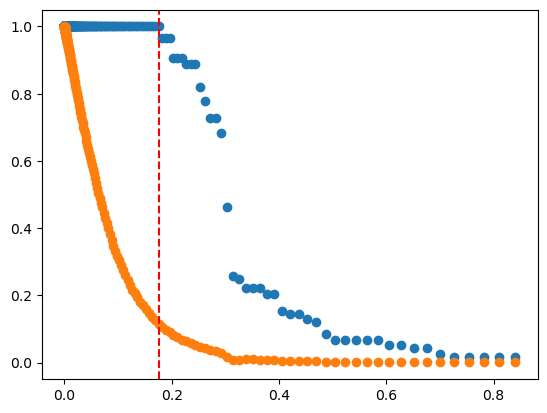

In [106]:
plt.plot(Th, Pinf, 'o', label='Pinf')
plt.plot(Th, Einf, 'o', label='Einf')
plt.axvline(th, color='r', linestyle='--', label='Threshold')

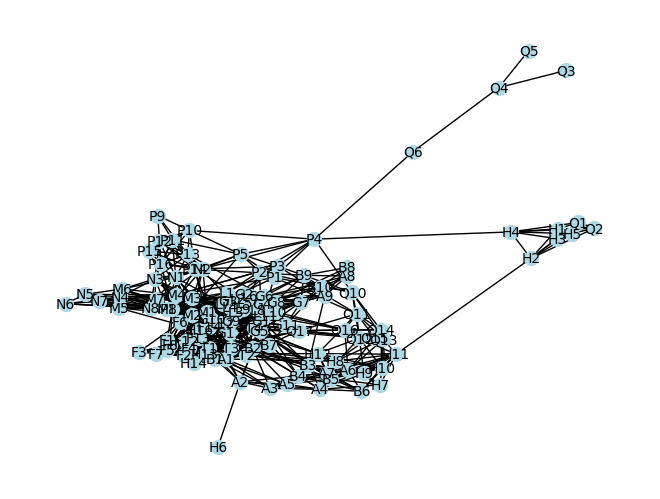

In [107]:
Cc[Cc < th] = 0
G = nx.from_numpy_array(Cc)
nx.draw(G, with_labels=True, node_size=100, node_color='lightblue', font_size=10, labels=ch_int_name_map)

In [108]:
#
GG = G.copy()
CC = Cc.copy()
networkEntropy = entropy(GG, t1=-3, t2=5, steps=400)
tau_scale = networkEntropy[-1]
speC = networkEntropy[1]/networkEntropy[1].max()
Sm1 = networkEntropy[0]/networkEntropy[0].max()
#

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/core.py:645: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/core.py:645: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


In [109]:
spectrum, L, rho, Trho, tau = compute_laplacian_properties(GG, tau=None)
dists = squareform(Trho)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, GG, method='ward')
FlatClusteringTh , *_ = compute_optimal_threshold(linkage_matrix)

In [114]:
FlatClusteringTh =1e-8
optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')

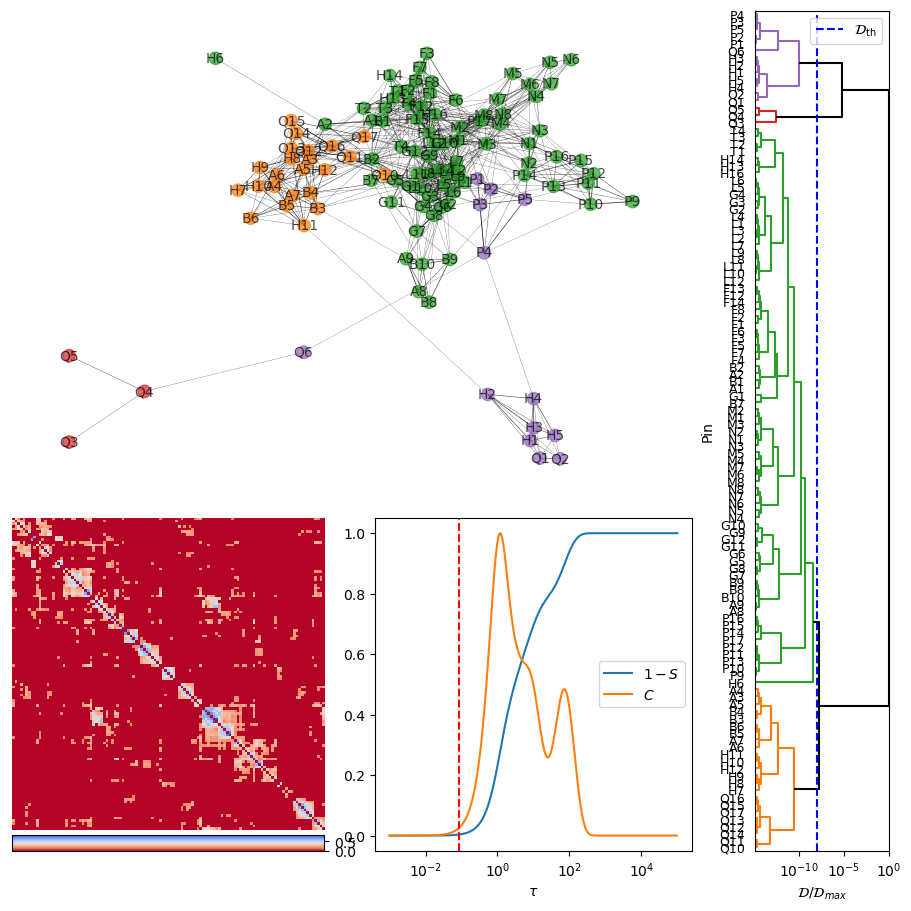

In [115]:
fig = plt.figure(constrained_layout=True,figsize=(9, 9))
#
ax_dict = fig.subplot_mosaic(
    """
    DDDDE
    DDDDE
    DDDDE
    BBCCE
    BBCCE
    """
)
#
im = ax_dict['B'].imshow(CC, cmap='coolwarm_r', interpolation='none')
imshow_colorbar_caxdivider(im, ax_dict['B'], position='bottom')#, orientation='horizontal')
ax_dict['B'].axis('off')
#
ax_dict['C'].plot(tau_scale, Sm1, label=r'$1-S$')
ax_dict['C'].plot(tau_scale[:-1], speC, label=r'$C$')
ax_dict['C'].set_xscale('log')
ax_dict['C'].legend()
ax_dict['C'].set_xlabel(r"$\tau$")
ax_dict['C'].axvline(tau, color = 'r', 
    linestyle = '--', )
#
relabel_list = [ch_int_name_map[nd] for nd in label_list]
dendro = dendrogram(linkage_matrix, ax=ax_dict['E'], 
                    color_threshold=FlatClusteringTh,
    above_threshold_color='k', leaf_font_size=9,
    labels=relabel_list, orientation='right')
tmin = linkage_matrix[::, 2][0] - 0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1] + 0.1*linkage_matrix[::, 2][-1]
#
ax_dict['E'].axvline(
    FlatClusteringTh, 
    color = 'b', 
    linestyle = '--', 
    label=r"$\mathcal{D}_{\rm th}$")
ax_dict['E'].set_xscale('log')
ax_dict['E'].set_xlim(tmin,tmax)
ax_dict['E'].legend()
ax_dict['E'].set_xlabel(r"$\mathcal{D}/\mathcal{D}_{max}$")
ax_dict['E'].set_ylabel('Pin')
#
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[label] for label in relabel_list]

widths = [GG[u][v]['weight'] for u, v in GG.edges()]
ch_int_name_map_ = {k: ch_int_name_map[k] for k in list(GG.nodes())}

pos = nx.spring_layout(GG, seed=5)

#
nx.draw(GG, pos=pos, ax=ax_dict['D'], node_size=80, font_size=10, width=widths, node_color=node_colors,alpha=0.7, with_labels=True, labels=ch_int_name_map, )
# plt.margins(0.0)
#


<Axes: xlabel='Time (samples)'>

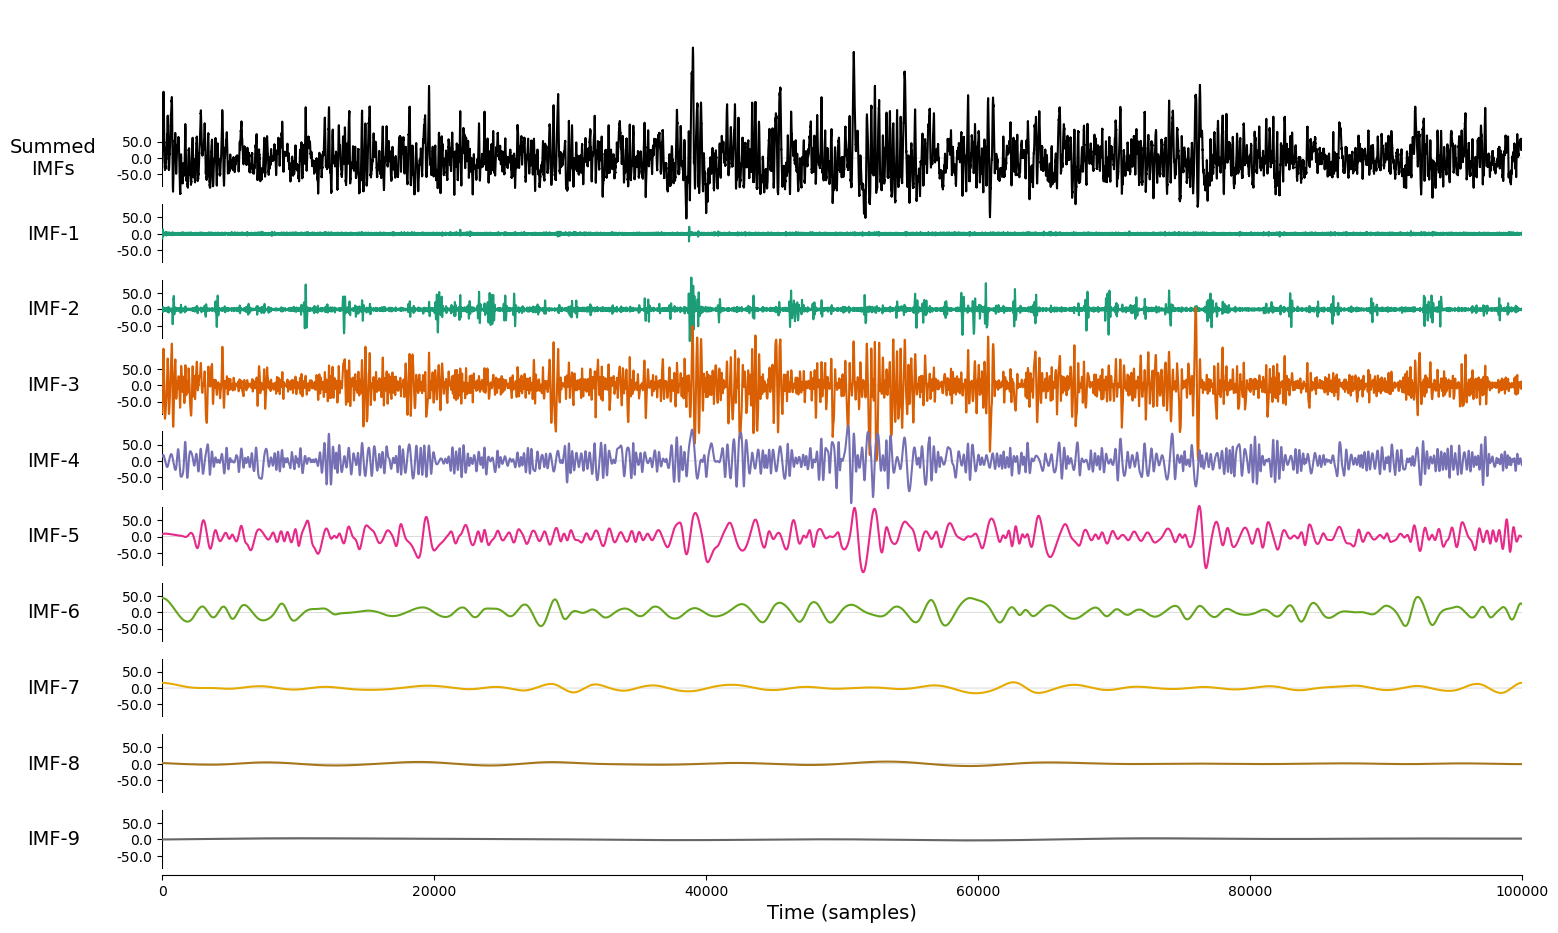

In [19]:
emd.plotting.plot_imfs(imf[0])